In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps_wyl import Place_net, Grid_net
import random 

# set random seed for reproducibility
seed = 0
np.random.seed(seed)
bm.random.seed(seed)
random.seed(seed)

In [2]:
z_min = 0
z_max = 20
map_num = 4 # number of place cell embedded maps
grid_num = 20
module_num = 10
a_p = 0.5
Spacing = np.linspace(6,20,module_num)

# only place cell
Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=1000, place_num=1000, noise_stre=0.5)
conn_mat = bm.as_numpy(Place_cell.conn_mat) # connection matrix neuron_num * neuron_num
maps = bm.as_numpy(Place_cell.map) 
place_index = bm.as_numpy(Place_cell.place_index) 

# couple net
Place_cell_couple = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=800, place_num=800, noise_stre=0.5)
Gird_module_list = bm.NodeList([])
for module in range(module_num):
    Grid_cell = Grid_net(L = Spacing[module], maps=bm.as_numpy(Place_cell_couple.map) , place_index=bm.as_numpy(Place_cell_couple.place_index) , neuron_num=grid_num, J0=5, a_g=a_p/Spacing[module]*2*bm.pi, W0=0.05)
    Gird_module_list.append(Grid_cell)
conn_out = Grid_cell.conn_out

## Global Remapping of place cells 
We first check how many neurons are re-used across different environments.

In [3]:
# Convert vectors to sets
set1 = set(place_index[0])
set2 = set(place_index[1])

# Find the intersection of the two sets
intersection = set1 & set2

# Calculate the number of elements in the intersection
Overlap_num = len(intersection)

# Convert the intersection to an array
Overlap_index = np.array(list(intersection), dtype=int)

# Output the results
print("Overlap place cell number:", Overlap_num)
# print('Overlap rate:', Overlap_num / place_num)
# print('Place rate:', place_num / neuron_num)
# print('Overlap index:', Overlap_index)

Overlap place cell number: 1000


Next, we check if the preferred location of overlap place cell are totally randomly shuffled across different environments: a hallmark of global remapping

(array([ 94., 118.,  87.,  84., 110., 119., 112.,  90.,  96.,  90.]),
 array([-9.95999908e+00, -7.96799898e+00, -5.97599888e+00, -3.98399901e+00,
        -1.99199903e+00,  9.53674316e-07,  1.99200094e+00,  3.98400092e+00,
         5.97600079e+00,  7.96800089e+00,  9.96000099e+00]),
 <BarContainer object of 10 artists>)

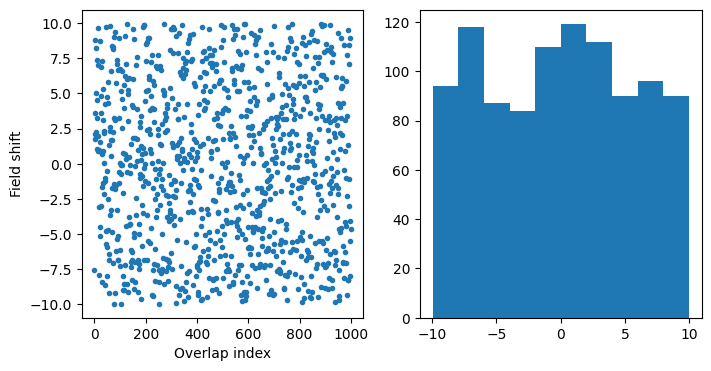

In [4]:
# Find the indices of Overlap_index elements in place_index
overlap_place_indices = np.zeros([map_num, Overlap_num])
overlap_place_fields = np.zeros([map_num, Overlap_num])
for i in range(map_num):
    indices = [np.where(place_index[i] == idx)[0][0] for idx in Overlap_index]
    overlap_place_indices[i] = indices
    overlap_place_fields[i] = maps[i][indices]


fig, ax = plt.subplots(1,2,figsize=(8,4))
distance = Place_cell.period_bound(overlap_place_fields[0]-overlap_place_fields[1])
ax[0].plot(Overlap_index, distance,'.')
ax[0].set_xlabel('Overlap index')
ax[0].set_ylabel('Field shift')
ax[1].hist(distance)

## Embedding Multiple CANNs in one network
First, we check the connection matrix of the network.

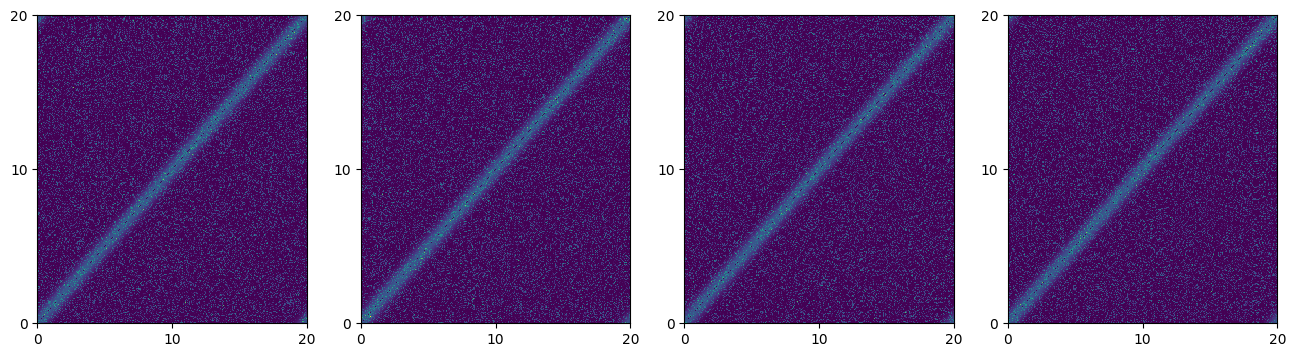

In [5]:
_, ax = plt.subplots(1, map_num, figsize=(map_num*4, 4))
for i in range(map_num):
  # Get sorted indices
  sorted_indices = np.argsort(maps[i])
  sorted_maps = maps[i, sorted_indices]
  sorted_place_index = place_index[i, sorted_indices]
  sorted_conn_mat = conn_mat[np.ix_(sorted_place_index, sorted_place_index)]

  # Visualize the matrix using pcolormesh
  ax[i].pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='viridis')
  # ax[i].colorbar()  # Add colorbar
  ax[i].set_xticks([0, 10, 20])
  ax[i].set_yticks([0, 10, 20])


[]

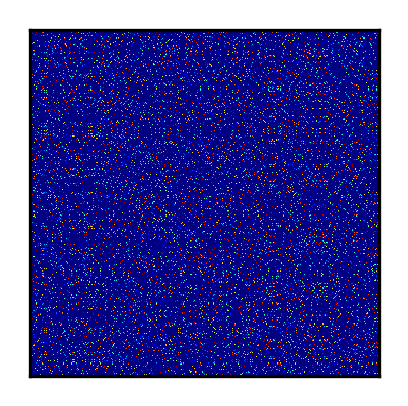

In [ ]:
# Visualize the connection matrix by the neural index of the 3rd map

_, ax = plt.subplots(1, 1, figsize=(1.5, 1.5),dpi=300)
i = 2
conn_mat_0 = Place_cell.make_conn(Place_cell.map[0])
mean_conn = bm.mean(conn_mat_0)
conn_mat_0 = conn_mat_0 - mean_conn
conn_mat_0 = bm.fill_diagonal(conn_mat_0, 0, inplace=False)

sorted_indices = np.argsort(maps[i])
sorted_maps = maps[i, sorted_indices]
sorted_place_index = place_index[i, sorted_indices]
sorted_conn_mat = conn_mat_0[np.ix_(sorted_place_index, sorted_place_index)]

c = ax.pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='jet')
# plt.colorbar(c, ax=ax)
# ax.set_xticks([0, 10, 20])
# ax.set_yticks([0, 10, 20])
ax.set_xticks([])
ax.set_yticks([])

[]

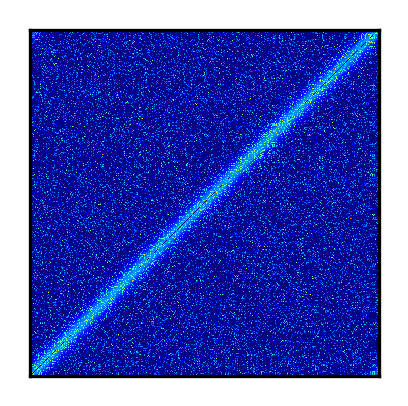

In [ ]:
# Visualize the connection matrix by the neural index of the 1st map

_, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)
i = 0
conn_mat_0 = Place_cell.make_conn(Place_cell.map[0])
mean_conn = bm.mean(conn_mat_0)
conn_mat_0 = conn_mat_0 - mean_conn
conn_mat_0 = bm.fill_diagonal(conn_mat_0, 0, inplace=False)

sorted_indices = np.argsort(maps[i])
sorted_maps = maps[i, sorted_indices]
sorted_place_index = place_index[i, sorted_indices]
sorted_conn_mat = conn_mat[np.ix_(sorted_place_index, sorted_place_index)]

c = ax.pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='jet')
# plt.colorbar(c, ax=ax)
# ax.set_xticks([0, 10, 20])
# ax.set_yticks([0, 10, 20])
ax.set_xticks([])
ax.set_yticks([])

## Activity

Next, we check the stationary states of a network embedding two maps in its connectivity.

In [7]:
Place_cell_0 = Place_net(z_min=z_min, z_max=z_max, map_num=1, neuron_num=1000, place_num=1000, noise_stre=0.5)
map_index = 0
def run_net(indices, loc, input_stre):
    Place_cell_0.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre)
    u = Place_cell_0.u
    input = Place_cell_0.input
    return u, input

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
us, input = bm.for_loop(run_net, (indices, loc, input_stre), progress_bar = True)

u_0 = Place_cell_0.r.value

  0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
map_index = 0

# 初始化网络
def initialize(indices, loc, input_stre):
    output = bm.zeros(Place_cell_couple.place_num,)
    for Grid_cell in Gird_module_list:
        Grid_cell.step_run(indices, r_hpc= Place_cell_couple.r, loc=loc, input_stre=input_stre, map_index = map_index)
        output += Grid_cell.output
    Place_cell_couple.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre, input_g = output)
    place_r = Place_cell_couple.r
    return output, place_r

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
output, place_r = bm.for_loop(initialize, (indices, loc, input_stre), progress_bar = True)

u_1 = Place_cell_couple.r.value

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
map_index = 0
def run_net(indices, loc, input_stre):
    Place_cell.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre)
    u = Place_cell.u
    input = Place_cell.input
    return u, input

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
us, input = bm.for_loop(run_net, (indices, loc, input_stre), progress_bar = True)

u_2 = Place_cell.r.value

  0%|          | 0/5000 [00:00<?, ?it/s]

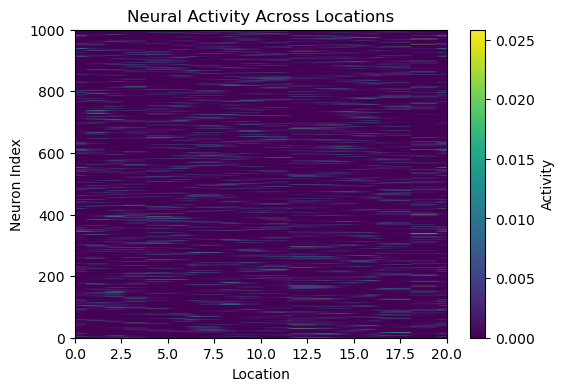

In [8]:
loc_num = 100
loc_candidate = bm.linspace(z_min, z_max, loc_num, endpoint=False)
activity_matrix = bm.zeros((loc_num, Place_cell.place_num))

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
loc_sequence = bm.zeros(total_time) 

for i, loc in enumerate(loc_candidate):
    loc_sequence[:] = loc
    bm.for_loop(run_net, (indices, loc_sequence, input_stre), progress_bar = False)
    activity_matrix[i] = bm.as_numpy(Place_cell.r.value)

### Visualization

#### Plot the activity of a single neuron

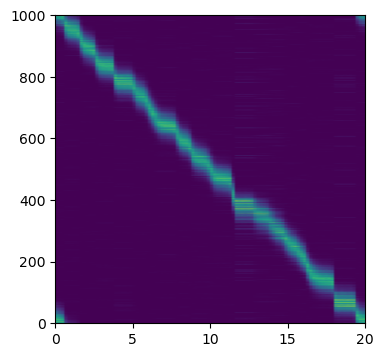

In [ ]:
u_place_active = activity_matrix[:, place_index[map_index]]
sorted_indices = np.argsort(maps[map_index])
sorted_maps = maps[map_index, sorted_indices]
sorted_u_place_active = u_place_active[:, sorted_indices]
flipped_sorted_u_place_active = np.flipud(sorted_u_place_active.T)

plt.figure(figsize=(4, 4))
plt.imshow(flipped_sorted_u_place_active, aspect='auto', origin='lower', extent=[z_min, z_max, 0, Place_cell.place_num])


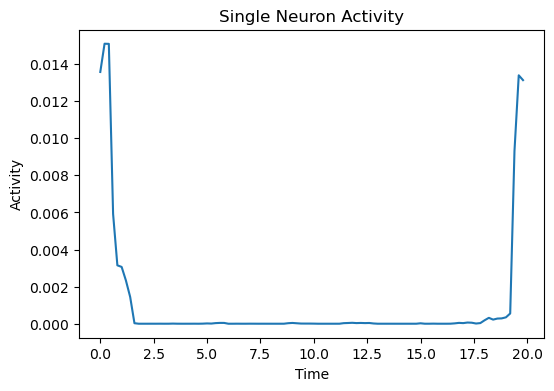

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(loc_candidate, sorted_u_place_active[:, 0])
plt.xlabel('Time')
plt.ylabel('Activity')
plt.title('Single Neuron Activity')
plt.show()

#### Plotting Population Activity

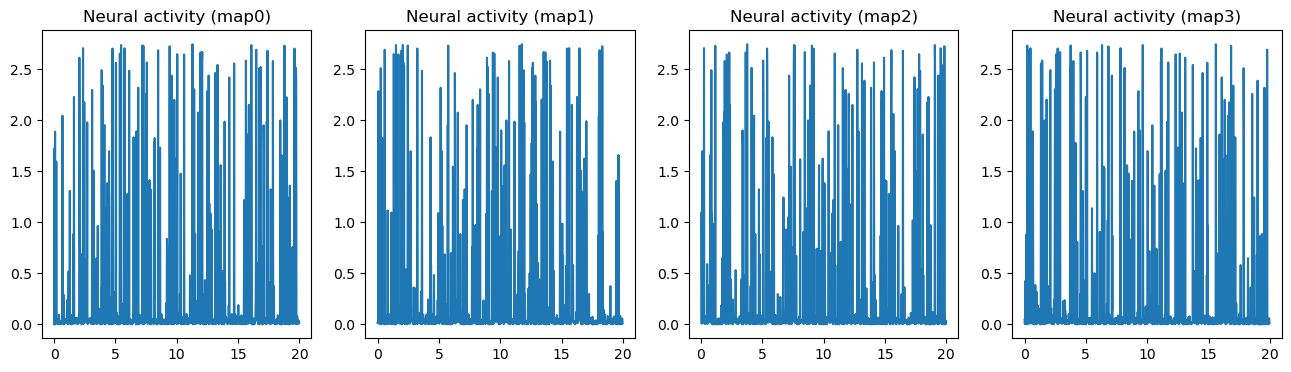

In [13]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(us[:, place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1,:])
    # ax[map_index].set_ylim([0, 5])
    ax[map_index].set_title('Neural activity (map'+str(map_index)+')')

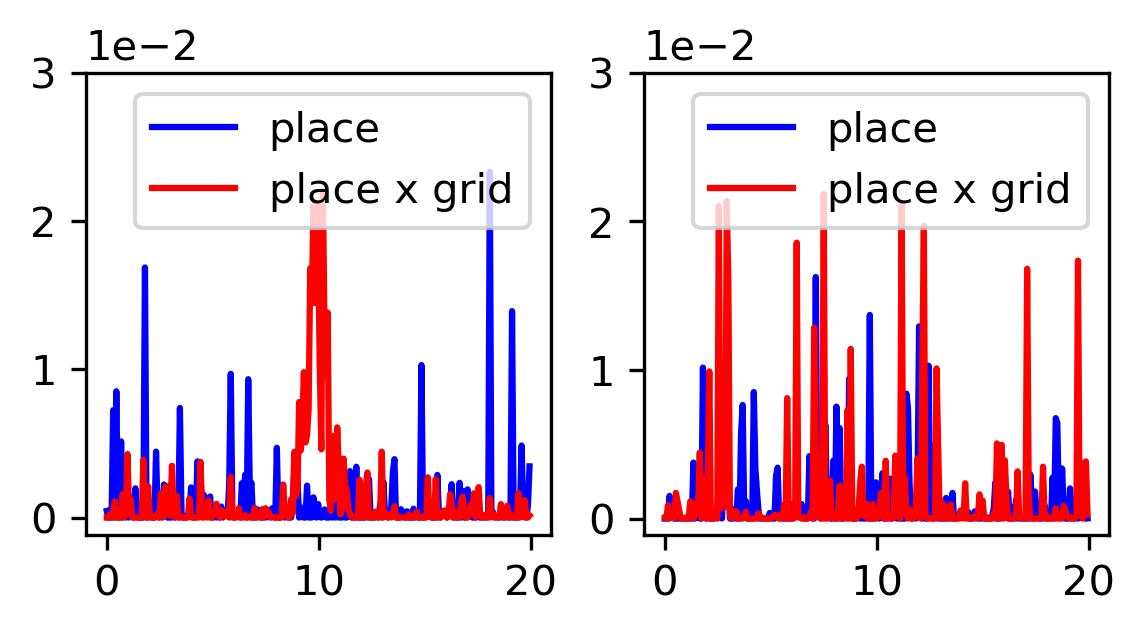

In [20]:
step = 3

_, ax = plt.subplots(1, 2, figsize=(4.4, 2), dpi=300)
for idx, map_index in enumerate([0, map_num - 1]):
    # u2
    u2_place = bm.as_numpy(u_2[place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u2_place = u2_place[sorted_indices]
    ax[idx].plot(sorted_maps[::step], sorted_u2_place[::step], label='place', color='blue')
    # u1
    u1_place = bm.as_numpy(u_1[place_index[map_index]])
    sorted_u1_place = u1_place[sorted_indices]
    ax[idx].plot(sorted_maps[::step], sorted_u1_place[::step], label='place x grid', color='red')
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax[idx].set_yticks([0, 0.01, 0.02, 0.03])
    ax[idx].legend()


In [29]:
maps = Place_cell.map

0.23577437
0.23577437


<Figure size 640x480 with 0 Axes>

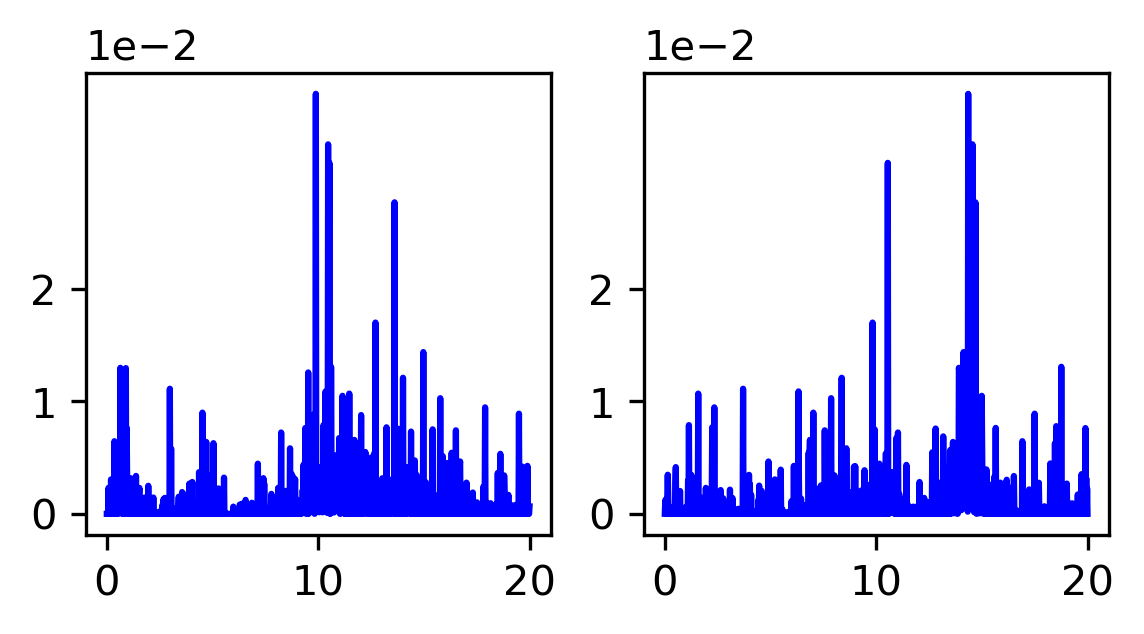

<Figure size 640x480 with 0 Axes>

In [33]:
u = u_2

loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)

for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
    bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

_, ax = plt.subplots(1, 2, figsize=(4.4, 2),dpi=300)
for idx, map_index in enumerate([0, map_num - 1]):
    u_place = bm.as_numpy(u[place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[sorted_indices]
    bump = Place_cell.get_bump(0, max_score_pos[0])
    sorted_bump_normalize = bump[sorted_indices]
    bump_height = bm.max(sorted_u_place[:])
    sorted_bump = sorted_bump_normalize * bump_height

    print(bm.sum(sorted_u_place / bm.sum(sorted_u_place) * sorted_bump_normalize))
    ax[idx].plot(sorted_maps, sorted_u_place, color='blue')
    # ax[idx].plot(sorted_maps, sorted_bump)
    
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax[idx].set_yticks([0, 0.01, 0.02])
    # ax[idx].set_yticks([0, 0.02, 0.04])

# print(bump_score)
# plt.savefig('figures/bump_activity.png')
plt.figure()
# plt.bar(np.arange(map_num), bump_score)
# plt.savefig('figures/bump_score.png')


[0.33027643 0.21749175 0.1998228  0.25154436 0.2007434  0.21530904
 0.24137232 0.4746475  0.2748118  0.16245341 0.23505545 0.19408953
 0.24861777 0.42650017 0.24403174 0.24598977 0.25568104 0.37553474
 0.17263289 0.39178592 0.19589722 0.26028663 0.22177032 0.27405375]


<BarContainer object of 24 artists>

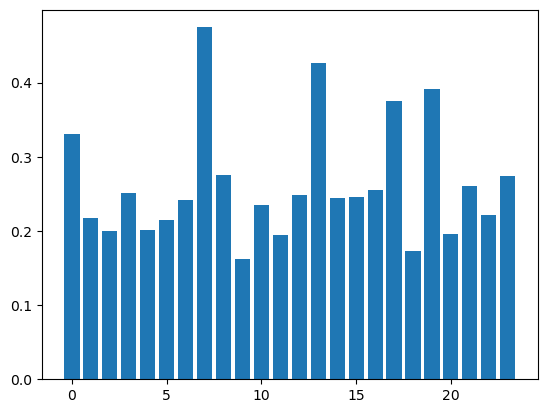

In [ ]:
# calulate bump score using cosine similarity
import jax
def cosine_similarity(a, b):
    dot_product = jax.numpy.dot(a, b)
    norm_a = jax.numpy.linalg.norm(a)
    norm_b = jax.numpy.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def compute_bump_score(u, loc_candidate, map_num, Place_cell, place_index):
    def body(map_index):
        u_place = u[place_index[map_index]]
        
        def score_func(loc):
            bump = Place_cell.get_bump(map_index, loc) 
            return cosine_similarity(bump, u_place)

        score_candidate = jax.vmap(score_func)(loc_candidate)
        return bm.max(score_candidate)
    bump_score = bm.for_loop(body, (bm.arange(map_num)), progress_bar=False)
    return bump_score

bump_score = compute_bump_score(u, loc_candidate, map_num=map_num, Place_cell=Place_cell, place_index=Place_cell.place_index)
print(bump_score)
plt.bar(np.arange(map_num), bump_score)

In [13]:
bump_score[0] - bm.max(bump_score[1:])

Array(0.16563573, dtype=float32)

Text(0, 0.5, 'Bump Score')

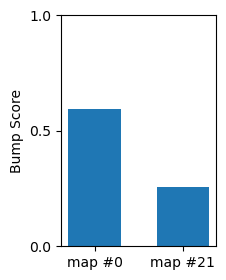

In [12]:
plt.figure(figsize=(2, 3))
plt.bar([0, 1], [bump_score[0], bump_score[-1]], width=0.6)
plt.xticks([0, 1], ['map #0', 'map #'+str(map_num-1)])

plt.yticks([0, 0.5, 1])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.ylabel('Bump Score')
# plt.title('Bump Score of First and Last Map')